# Model Validation


## Imports


In [1]:
import os
import gc
import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import DataLoader

import warnings
from notebooks_config import setup_logging, CustomLogger

from src.BiomassDataset import BiomassDataset

from src.image_transforms import get_transforms
from src.cv import create_folds_with_date_groups

warnings.simplefilter(action='ignore', category=FutureWarning)
print(f"PyTorch: {torch.__version__}")

Available variables: ['BASE_DIR', 'DATA_DIR', 'Path', 'directory', 'find_project_root', 'project_root', 'sys']
PyTorch: 2.9.1+cu128


In [2]:
PATH_DATA = './kaggle/input/csiro-biomass'
PATH_TRAIN_CSV = os.path.join(PATH_DATA, 'train.csv')
PATH_TRAIN_IMG = os.path.join(PATH_DATA, 'train')

BATCH_SIZE = 16
NUM_WORKERS = 0
N_FOLDS = 5

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

Using device: cuda


In [3]:
# Target names
ALL_TARGETS = ['Dry_Clover_g', 'Dry_Dead_g',
               'Dry_Green_g', 'Dry_Total_g', 'GDM_g']
USED_TARGETS = ['Dry_Green_g', 'Dry_Total_g', 'GDM_g']

In [4]:
MODELS_DIR = "./kaggle/input/csiro-models/pytorch/default/5"

## Load Data


In [5]:
df = pd.read_csv(PATH_TRAIN_CSV)
df = df[df['target_name'].isin(USED_TARGETS)].reset_index(drop=True)
print(f"Dataset size: {df.shape}")

# Pivot to one row per image
df_pivoted = df.pivot_table(
    index=['image_path', 'Sampling_Date', 'State', 'Species'],
    columns='target_name',
    values='target'
).reset_index()

print(f"Pivoted dataset: {df_pivoted.shape}")
display(df_pivoted.head())

Dataset size: (1071, 9)
Pivoted dataset: (357, 7)


target_name,image_path,Sampling_Date,State,Species,Dry_Green_g,Dry_Total_g,GDM_g
0,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,16.2750,48.2735,16.2750
1,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,7.6000,7.6000,7.6000
2,train/ID1025234388.jpg,2015/9/1,WA,SubcloverDalkeith,0.0000,6.0500,6.0500
3,train/ID1028611175.jpg,2015/5/18,Tas,Ryegrass,24.2376,55.2079,24.2376
4,train/ID1035947949.jpg,2015/9/11,Tas,Ryegrass,10.5261,34.1844,10.9605


## Tools


### Competition Metric


In [6]:
labels = ["Dry_Clover_g", "Dry_Dead_g", "Dry_Green_g", "Dry_Total_g", "GDM_g"]

weights = {
    'Dry_Clover_g': 0.1,
    'Dry_Dead_g': 0.1,
    'Dry_Green_g': 0.1,
    'Dry_Total_g': 0.5,
    'GDM_g': 0.2,
}


def competition_metric(y_true, y_pred) -> float:
    """Calculate competition's weighted R2 score."""
    weights_array = np.array([weights[l] for l in labels])

    y_weighted_mean = np.average(y_true, weights=weights_array, axis=1).mean()

    ss_res = np.average((y_true - y_pred)**2,
                        weights=weights_array, axis=1).mean()
    ss_tot = np.average((y_true - y_weighted_mean)**2,
                        weights=weights_array, axis=1).mean()

    return 1 - ss_res / ss_tot

### Helper Functions


In [22]:
def expand_predictions(preds_3: torch.Tensor) -> torch.Tensor:
    """
    Convert [B, 3] predictions to [B, 5] submission format.

    Model predicts: [Dry_Green_g, Dry_Total_g, GDM_g]
    Submission needs: [Dry_Clover_g, Dry_Dead_g, Dry_Green_g, Dry_Total_g, GDM_g]
    """
    green = preds_3[:, 0]   # Dry_Green_g (predicted)
    total = preds_3[:, 1]   # Dry_Total_g (predicted)
    gdm = preds_3[:, 2]     # GDM_g (predicted)

    # Calculate missing targets
    dead = total - gdm      # Dry_Dead_g = Total - GDM
    clover = gdm - green    # Dry_Clover_g = GDM - Green

    # EXPERIMENTAL: take log of dead and clover to reduce negative predictions
    dead = torch.log1p(torch.clamp(dead, min=0.0))
    clover = torch.log1p(torch.clamp(clover, min=0.0))

    # Ensure no negative values
    dead = torch.clamp(dead, min=0.0)
    clover = torch.clamp(clover, min=0.0)

    # Return in competition order
    return torch.stack([clover, dead, green, total, gdm], dim=1)

In [23]:
def get_validation_loader(
    df: pd.DataFrame,
    fold: int,
    img_size: int,
    mean: list[float],
    std: list[float],
    use_log_target: bool,
    seed: int,
    batch_size: int,
    num_workers: int
) -> tuple[DataLoader, pd.DataFrame]:
    """Create validation dataloader for specific fold."""

    # Create folds with same seed as training
    df_with_folds = create_folds_with_date_groups(
        df,
        n_folds=N_FOLDS,
        use_mass_stratification=True,
        n_mass_bins=5,
        mass_col='Dry_Total_g',
        random_state=seed
    )

    # Get validation fold
    val_df = df_with_folds[df_with_folds['fold']
                           == fold].reset_index(drop=True)
    print(f"Validation fold {fold} size: {len(val_df)}")

    # Create transforms
    _, val_transform = get_transforms(img_size, mean, std)

    # Create dataset
    val_dataset = BiomassDataset(
        df=val_df,
        target_cols=USED_TARGETS,
        img_dir=PATH_TRAIN_IMG,
        transform=val_transform,
        is_test=False,
        use_log_target=use_log_target
    )

    # Create dataloader
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )

    return val_loader, val_df

In [24]:
def validate_model(
    model: nn.Module,
    val_loader: DataLoader,
    use_log_target: bool,
    device: torch.device
) -> tuple[np.ndarray, np.ndarray]:
    """
    Run validation and return predictions and targets.

    Returns:
        predictions: [N, 5] array in original scale
        targets: [N, 5] array in original scale
    """
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            left = batch['left_image'].to(device)
            right = batch['right_image'].to(device)
            targets = batch['targets'].to(device)

            # Get predictions [B, 3] - already in original scale from traced model!
            preds_3 = model(left, right)
            preds_3 = torch.clamp(preds_3, min=0.0)

            # Expand to [B, 5]
            preds_5 = expand_predictions(preds_3)

            # Convert targets to original scale if log was used
            if use_log_target:
                targets_expanded = expand_predictions(targets)
                targets_expanded = torch.expm1(targets_expanded)
            else:
                targets_expanded = expand_predictions(targets)

            # NO expm1 for predictions - model already returns original scale!
            all_preds.append(preds_5.cpu().numpy())
            all_targets.append(targets_expanded.cpu().numpy())

    predictions = np.concatenate(all_preds, axis=0)
    targets = np.concatenate(all_targets, axis=0)

    return predictions, targets

In [25]:
def analyze_errors(
    predictions: np.ndarray,
    targets: np.ndarray,
    target_names: list[str],
    model_name: str
) -> dict:
    """Analyze prediction errors for each target."""

    results = {}

    for i, target_name in enumerate(target_names):
        y_true = targets[:, i]
        y_pred = predictions[:, i]

        # Calculate metrics
        errors = y_pred - y_true
        abs_errors = np.abs(errors)
        rel_errors = errors / (y_true + 1e-6)  # Avoid division by zero

        # Calculate R² using competition metric (requires 2D arrays)
        # Reshape to [N, 1] and then expand to [N, 5] with zeros for other targets
        y_true_full = np.zeros((len(y_true), 5))
        y_pred_full = np.zeros((len(y_pred), 5))
        y_true_full[:, i] = y_true
        y_pred_full[:, i] = y_pred

        # Use competition metric for this single target
        r2 = competition_metric(y_true_full, y_pred_full)

        mae = np.mean(abs_errors)
        rmse = np.sqrt(np.mean(errors ** 2))

        # Error statistics
        overpredict_ratio = np.mean(errors > 0)
        underpredict_ratio = np.mean(errors < 0)

        results[target_name] = {
            'r2': r2,
            'mae': mae,
            'rmse': rmse,
            'mean_error': np.mean(errors),
            'std_error': np.std(errors),
            'median_error': np.median(errors),
            'overpredict_ratio': overpredict_ratio,
            'underpredict_ratio': underpredict_ratio,
            'errors': errors,
            'abs_errors': abs_errors,
            'rel_errors': rel_errors,
            'y_true': y_true,
            'y_pred': y_pred
        }

    return results

In [26]:
def get_size_mean_std(ckpt_path: str) -> tuple[int, list[float], list[float]]:
    """Get input size, mean, and std for a given model."""
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img_size = 224  # Default

    ckpt_path = ckpt_path.lower()

    if 'convnextv2_tiny' in ckpt_path:
        img_size = 384
        print(f"✅ Config hardcoded for ConvNeXtV2 Tiny")
    elif 'dinov2' in ckpt_path:
        img_size = 518
        print(f"✅ Config hardcoded for DINOv2 ViT Large/Giant")

    return img_size, mean, std

In [27]:
def get_fold_id(ckpt_path: str) -> int:
    """Extract fold ID from checkpoint path."""
    base_name = os.path.basename(ckpt_path)
    parts = base_name.split('-')
    for part in parts:
        if part.startswith('fold'):
            try:
                fold_id = int(part.replace('fold', ''))
                return fold_id
            except ValueError:
                continue
    raise ValueError(f"Fold ID not found in checkpoint path: {ckpt_path}")

### Visualization Functions


In [28]:
def plot_error_distribution(results: dict, model_name: str, save_path: str | None = None):
    """Plot error distributions for all targets."""

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()

    for i, (target_name, metrics) in enumerate(results.items()):
        ax = axes[i]

        errors = metrics['errors']

        # Plot histogram and KDE
        ax.hist(errors, bins=50, alpha=0.6, density=True, label='Histogram')

        # KDE
        from scipy import stats
        kde = stats.gaussian_kde(errors)
        x_range = np.linspace(errors.min(), errors.max(), 200)
        ax.plot(x_range, kde(x_range), 'r-', linewidth=2, label='PDF (KDE)')

        # Add vertical line at 0
        ax.axvline(x=0, color='black', linestyle='--',
                   linewidth=1.5, alpha=0.7)

        # Add mean and median
        ax.axvline(x=metrics['mean_error'], color='blue', linestyle='--',
                   linewidth=1.5, label=f"Mean: {metrics['mean_error']:.2f}")
        ax.axvline(x=metrics['median_error'], color='green', linestyle='--',
                   linewidth=1.5, label=f"Median: {metrics['median_error']:.2f}")

        ax.set_title(f"{target_name}\nR²={metrics['r2']:.4f}, RMSE={metrics['rmse']:.2f}",
                     fontsize=12, fontweight='bold')
        ax.set_xlabel('Prediction Error (g)', fontsize=10)
        ax.set_ylabel('Density', fontsize=10)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

    # Remove extra subplot
    fig.delaxes(axes[-1])

    plt.suptitle(f'Error Distribution Analysis - {model_name}',
                 fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

In [29]:
def plot_prediction_scatter(results: dict, model_name: str, save_path: str | None = None):
    """Plot prediction vs true values scatter plots."""

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()

    for i, (target_name, metrics) in enumerate(results.items()):
        ax = axes[i]

        y_true = metrics['y_true']
        y_pred = metrics['y_pred']

        # Scatter plot
        ax.scatter(y_true, y_pred, alpha=0.5, s=20)

        # Perfect prediction line
        min_val = min(y_true.min(), y_pred.min())
        max_val = max(y_true.max(), y_pred.max())
        ax.plot([min_val, max_val], [min_val, max_val],
                'r--', linewidth=2, label='Perfect prediction')

        # Add R² and RMSE
        ax.text(0.05, 0.95, f"R² = {metrics['r2']:.4f}\nRMSE = {metrics['rmse']:.2f}",
                transform=ax.transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        ax.set_title(f"{target_name}", fontsize=12, fontweight='bold')
        ax.set_xlabel('True Value (g)', fontsize=10)
        ax.set_ylabel('Predicted Value (g)', fontsize=10)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

    # Remove extra subplot
    fig.delaxes(axes[-1])

    plt.suptitle(f'Prediction vs True Values - {model_name}',
                 fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

In [30]:
def plot_error_analysis_summary(all_results: dict[str, dict], save_path: str | None = None):
    """Create summary comparison of all models."""

    models = list(all_results.keys())
    target_names = ALL_TARGETS

    # Create metrics comparison
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # R² comparison
    ax = axes[0, 0]
    r2_data = []
    for model in models:
        r2_values = [all_results[model][target]['r2']
                     for target in target_names]
        r2_data.append(r2_values)

    x = np.arange(len(target_names))
    width = 0.8 / len(models)

    for i, (model, r2_values) in enumerate(zip(models, r2_data)):
        offset = width * i - (width * len(models) / 2 - width / 2)
        ax.bar(x + offset, r2_values, width, label=model, alpha=0.8)

    ax.set_xlabel('Target', fontsize=12, fontweight='bold')
    ax.set_ylabel('R² Score', fontsize=12, fontweight='bold')
    ax.set_title('R² Score Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(target_names, rotation=45, ha='right')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3, axis='y')

    # RMSE comparison
    ax = axes[0, 1]
    rmse_data = []
    for model in models:
        rmse_values = [all_results[model][target]['rmse']
                       for target in target_names]
        rmse_data.append(rmse_values)

    for i, (model, rmse_values) in enumerate(zip(models, rmse_data)):
        offset = width * i - (width * len(models) / 2 - width / 2)
        ax.bar(x + offset, rmse_values, width, label=model, alpha=0.8)

    ax.set_xlabel('Target', fontsize=12, fontweight='bold')
    ax.set_ylabel('RMSE (g)', fontsize=12, fontweight='bold')
    ax.set_title('RMSE Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(target_names, rotation=45, ha='right')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3, axis='y')

    # Over/Under prediction ratio
    ax = axes[1, 0]
    for model in models:
        over_ratios = [all_results[model][target]['overpredict_ratio']
                       for target in target_names]
        ax.plot(target_names, over_ratios,
                marker='o', label=model, linewidth=2)

    ax.axhline(y=0.5, color='red', linestyle='--',
               linewidth=1.5, alpha=0.7, label='Perfect balance')
    ax.set_xlabel('Target', fontsize=12, fontweight='bold')
    ax.set_ylabel('Overprediction Ratio', fontsize=12, fontweight='bold')
    ax.set_title('Overprediction Ratio (>0.5 = tends to overpredict)',
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

    # Mean absolute error
    ax = axes[1, 1]
    mae_data = []
    for model in models:
        mae_values = [all_results[model][target]['mae']
                      for target in target_names]
        mae_data.append(mae_values)

    for i, (model, mae_values) in enumerate(zip(models, mae_data)):
        offset = width * i - (width * len(models) / 2 - width / 2)
        ax.bar(x + offset, mae_values, width, label=model, alpha=0.8)

    ax.set_xlabel('Target', fontsize=12, fontweight='bold')
    ax.set_ylabel('MAE (g)', fontsize=12, fontweight='bold')
    ax.set_title('Mean Absolute Error Comparison',
                 fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(target_names, rotation=45, ha='right')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3, axis='y')

    plt.suptitle('Model Comparison Summary',
                 fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

In [31]:
def plot_target_distributions(results: dict, model_name: str, save_path: str | None = None):
    """Plot PDF distributions of true vs predicted values for each target."""

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()

    for i, (target_name, metrics) in enumerate(results.items()):
        ax = axes[i]

        y_true = metrics['y_true']
        y_pred = metrics['y_pred']

        # Create KDE for true and predicted values
        from scipy import stats

        # KDE for true values
        kde_true = stats.gaussian_kde(y_true)
        x_range_true = np.linspace(y_true.min(), y_true.max(), 200)

        # KDE for predicted values
        kde_pred = stats.gaussian_kde(y_pred)
        x_range_pred = np.linspace(y_pred.min(), y_pred.max(), 200)

        # Combined range for better visualization
        x_min = min(y_true.min(), y_pred.min())
        x_max = max(y_true.max(), y_pred.max())
        x_range = np.linspace(x_min, x_max, 300)

        # Plot PDFs
        ax.plot(x_range, kde_true(x_range), 'b-', linewidth=2.5,
                label=f'True (μ={y_true.mean():.2f}, σ={y_true.std():.2f})', alpha=0.8)
        ax.plot(x_range, kde_pred(x_range), 'r-', linewidth=2.5,
                label=f'Predicted (μ={y_pred.mean():.2f}, σ={y_pred.std():.2f})', alpha=0.8)

        # Fill areas for better visibility
        ax.fill_between(x_range, kde_true(x_range), alpha=0.2, color='blue')
        ax.fill_between(x_range, kde_pred(x_range), alpha=0.2, color='red')

        # Add vertical lines for means
        ax.axvline(x=y_true.mean(), color='blue', linestyle='--',
                   linewidth=1.5, alpha=0.6)
        ax.axvline(x=y_pred.mean(), color='red', linestyle='--',
                   linewidth=1.5, alpha=0.6)

        # Add metrics to title
        ax.set_title(f"{target_name}\nR²={metrics['r2']:.4f}, RMSE={metrics['rmse']:.2f} g",
                     fontsize=12, fontweight='bold')
        ax.set_xlabel('Value (g)', fontsize=10)
        ax.set_ylabel('Probability Density', fontsize=10)
        ax.legend(fontsize=9, loc='best')
        ax.grid(True, alpha=0.3)

    # Remove extra subplot
    fig.delaxes(axes[-1])

    plt.suptitle(f'Target Distribution Comparison - {model_name}',
                 fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

## Model Evaluation


In [32]:
all_models = glob.glob(os.path.join(MODELS_DIR, "*.pt"))
all_models

['./kaggle/input/csiro-models/pytorch/default/5\\convnextv2_tiny.fcmae_ft_in22k_in1k_384-fold4-r2_0.8041.pt',
 './kaggle/input/csiro-models/pytorch/default/5\\convnext_base.fb_in22k_ft_in1k-fold0-r2_0.7422.pt',
 './kaggle/input/csiro-models/pytorch/default/5\\GPU_vit_large_patch16_dinov3.lvd1689m-fold1-r2_0.8214.pt',
 './kaggle/input/csiro-models/pytorch/default/5\\vit_large_patch14_dinov2.lvd142m-fold4-r2_0.7603.pt']

In [33]:
MODEL_CONFIGS = {}
default_config = {
    'img_size': 224,
    'mean': [0.485, 0.456, 0.406],
    'std': [0.229, 0.224, 0.225],
    'seed': 42,
    'fold': 0,
    'use_log_target': True
}

for ckpt_path in all_models:
    model_name = os.path.basename(ckpt_path)
    MODEL_CONFIGS[model_name] = default_config.copy()

MODEL_CONFIGS

{'convnextv2_tiny.fcmae_ft_in22k_in1k_384-fold4-r2_0.8041.pt': {'img_size': 224,
  'mean': [0.485, 0.456, 0.406],
  'std': [0.229, 0.224, 0.225],
  'seed': 42,
  'fold': 0,
  'use_log_target': True},
 'convnext_base.fb_in22k_ft_in1k-fold0-r2_0.7422.pt': {'img_size': 224,
  'mean': [0.485, 0.456, 0.406],
  'std': [0.229, 0.224, 0.225],
  'seed': 42,
  'fold': 0,
  'use_log_target': True},
 'GPU_vit_large_patch16_dinov3.lvd1689m-fold1-r2_0.8214.pt': {'img_size': 224,
  'mean': [0.485, 0.456, 0.406],
  'std': [0.229, 0.224, 0.225],
  'seed': 42,
  'fold': 0,
  'use_log_target': True},
 'vit_large_patch14_dinov2.lvd142m-fold4-r2_0.7603.pt': {'img_size': 224,
  'mean': [0.485, 0.456, 0.406],
  'std': [0.229, 0.224, 0.225],
  'seed': 42,
  'fold': 0,
  'use_log_target': True}}

In [34]:
for ckpt_path in all_models:
    model_name = os.path.basename(ckpt_path)
    img_size, mean, std = get_size_mean_std(ckpt_path)
    fold = get_fold_id(ckpt_path)

    MODEL_CONFIGS[model_name]['img_size'] = img_size
    MODEL_CONFIGS[model_name]['mean'] = mean
    MODEL_CONFIGS[model_name]['std'] = std
    MODEL_CONFIGS[model_name]['fold'] = fold

MODEL_CONFIGS

✅ Config hardcoded for ConvNeXtV2 Tiny
✅ Config hardcoded for DINOv2 ViT Large/Giant


{'convnextv2_tiny.fcmae_ft_in22k_in1k_384-fold4-r2_0.8041.pt': {'img_size': 384,
  'mean': [0.485, 0.456, 0.406],
  'std': [0.229, 0.224, 0.225],
  'seed': 42,
  'fold': 4,
  'use_log_target': True},
 'convnext_base.fb_in22k_ft_in1k-fold0-r2_0.7422.pt': {'img_size': 224,
  'mean': [0.485, 0.456, 0.406],
  'std': [0.229, 0.224, 0.225],
  'seed': 42,
  'fold': 0,
  'use_log_target': True},
 'GPU_vit_large_patch16_dinov3.lvd1689m-fold1-r2_0.8214.pt': {'img_size': 224,
  'mean': [0.485, 0.456, 0.406],
  'std': [0.229, 0.224, 0.225],
  'seed': 42,
  'fold': 1,
  'use_log_target': True},
 'vit_large_patch14_dinov2.lvd142m-fold4-r2_0.7603.pt': {'img_size': 518,
  'mean': [0.485, 0.456, 0.406],
  'std': [0.229, 0.224, 0.225],
  'seed': 42,
  'fold': 4,
  'use_log_target': True}}

In [35]:
# Manual changes if needed
MODEL_CONFIGS['convnextv2_tiny.fcmae_ft_in22k_in1k_384-fold4-r2_0.8041.pt']['seed'] = 1488


Validating: convnextv2_tiny.fcmae_ft_in22k_in1k_384-fold4-r2_0.8041.pt


c:\_GitHub\CSIRO-Image2Biomass-Prediction\.venv\Lib\site-packages\torch\serialization.py:1493: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn(


✅ Model loaded successfully

Fold 0:
  Train samples: 283
  Val samples: 74
  ✓ No date overlap (train: 23 dates, val: 5 dates)

Fold 1:
  Train samples: 286
  Val samples: 71
  ✓ No date overlap (train: 22 dates, val: 6 dates)

Fold 2:
  Train samples: 287
  Val samples: 70
  ✓ No date overlap (train: 22 dates, val: 6 dates)

Fold 3:
  Train samples: 277
  Val samples: 80
  ✓ No date overlap (train: 22 dates, val: 6 dates)

Fold 4:
  Train samples: 295
  Val samples: 62
  ✓ No date overlap (train: 23 dates, val: 5 dates)
FOLD QUALITY VERIFICATION

Fold 0:
  Samples: 74
  State distribution:
    Vic: 39.2%
    NSW: 25.7%
    Tas: 24.3%
    WA: 10.8%
  Species distribution:
    Ryegrass_Clover: 24.3%
    Lucerne: 13.5%
    Ryegrass: 13.5%
    Phalaris_Clover: 13.5%
    Fescue: 12.2%
    Clover: 10.8%
    Phalaris_Ryegrass_Clover: 9.5%
    Mixed: 2.7%
  Season distribution:
    Winter: 74.3%
    Autumn: 13.5%
    Summer: 12.2%
  Mass bin distribution:
    mass_bin_0: 24.3%
    mass_bin_1

Validating: 100%|██████████| 4/4 [00:10<00:00,  2.59s/it]



📊 Results for convnextv2_tiny.fcmae_ft_in22k_in1k_384-fold4-r2_0.8041.pt:
  Dry_Clover_g:
    R² = -58.7632
    RMSE = 2.29 g
    MAE = 2.14 g
    Mean Error = 2.14 g
    Overprediction Ratio = 98.39%
  Dry_Dead_g:
    R² = -20.4628
    RMSE = 1.83 g
    MAE = 1.68 g
    Mean Error = 1.66 g
    Overprediction Ratio = 91.94%
  Dry_Green_g:
    R² = 0.7467
    RMSE = 16.36 g
    MAE = 11.53 g
    Mean Error = -9.10 g
    Overprediction Ratio = 32.26%
  Dry_Total_g:
    R² = 0.8761
    RMSE = 14.26 g
    MAE = 10.81 g
    Mean Error = -1.90 g
    Overprediction Ratio = 51.61%
  GDM_g:
    R² = 0.9372
    RMSE = 10.09 g
    MAE = 7.26 g
    Mean Error = -0.50 g
    Overprediction Ratio = 50.00%

🏆 Competition R² Score: 0.8028


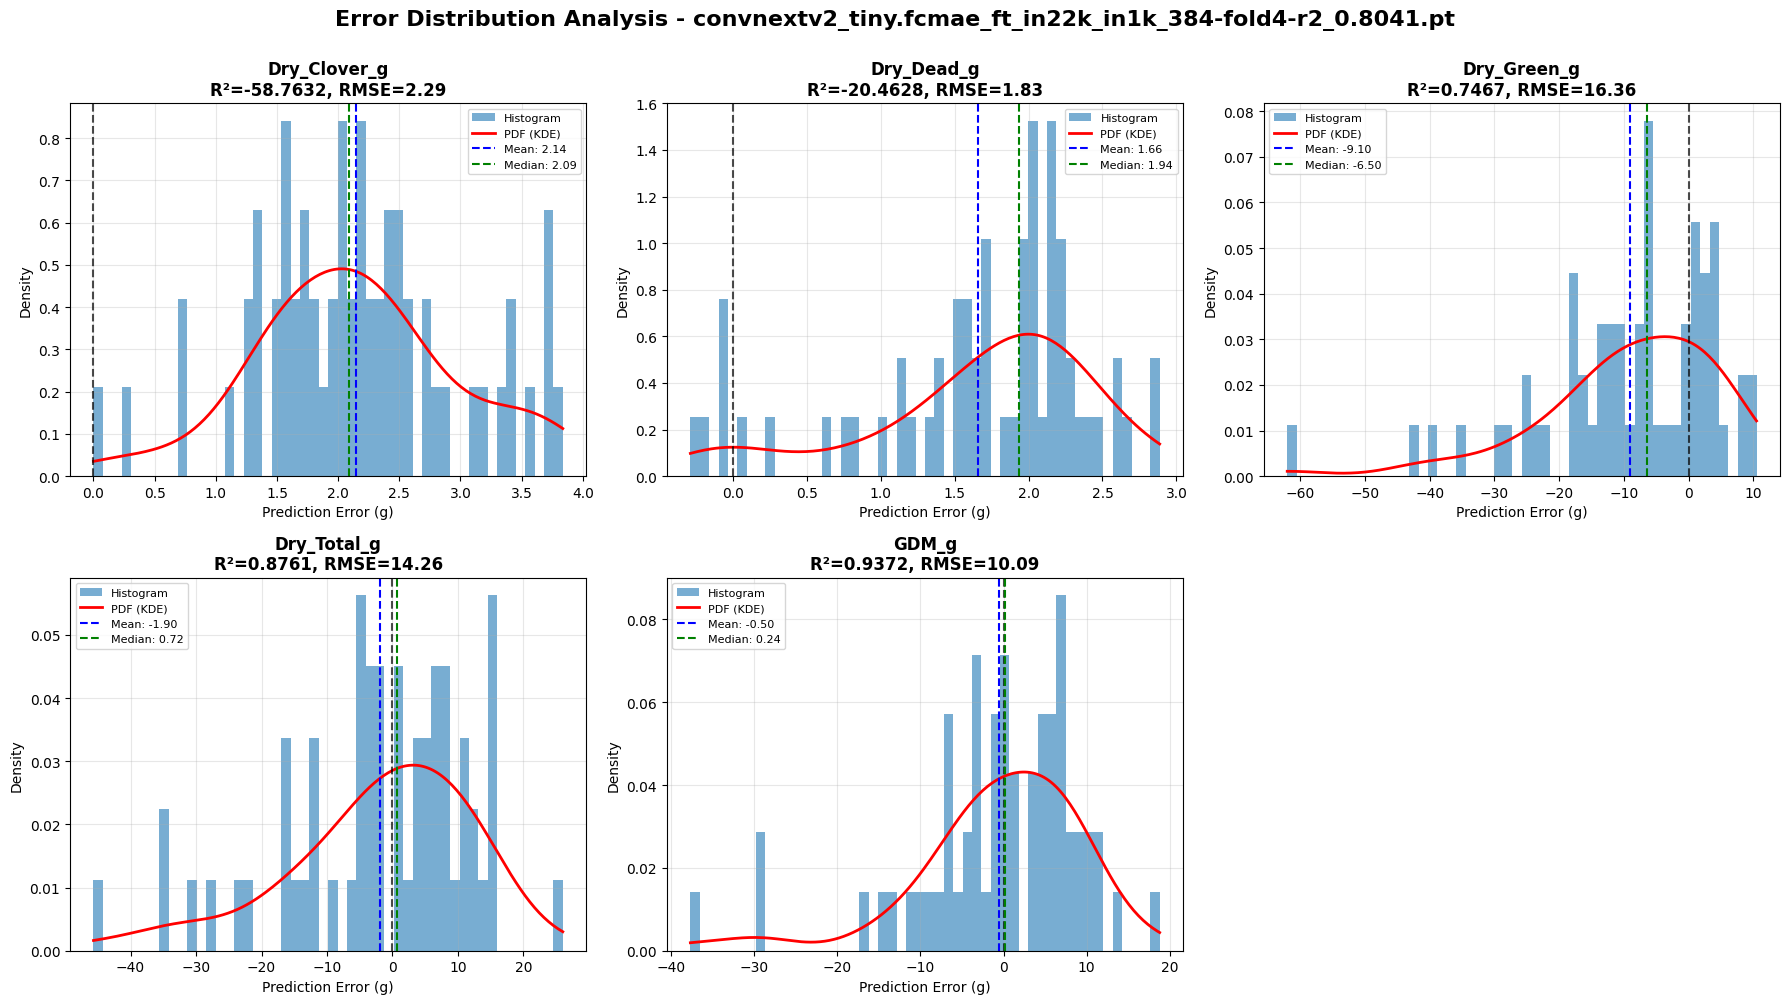

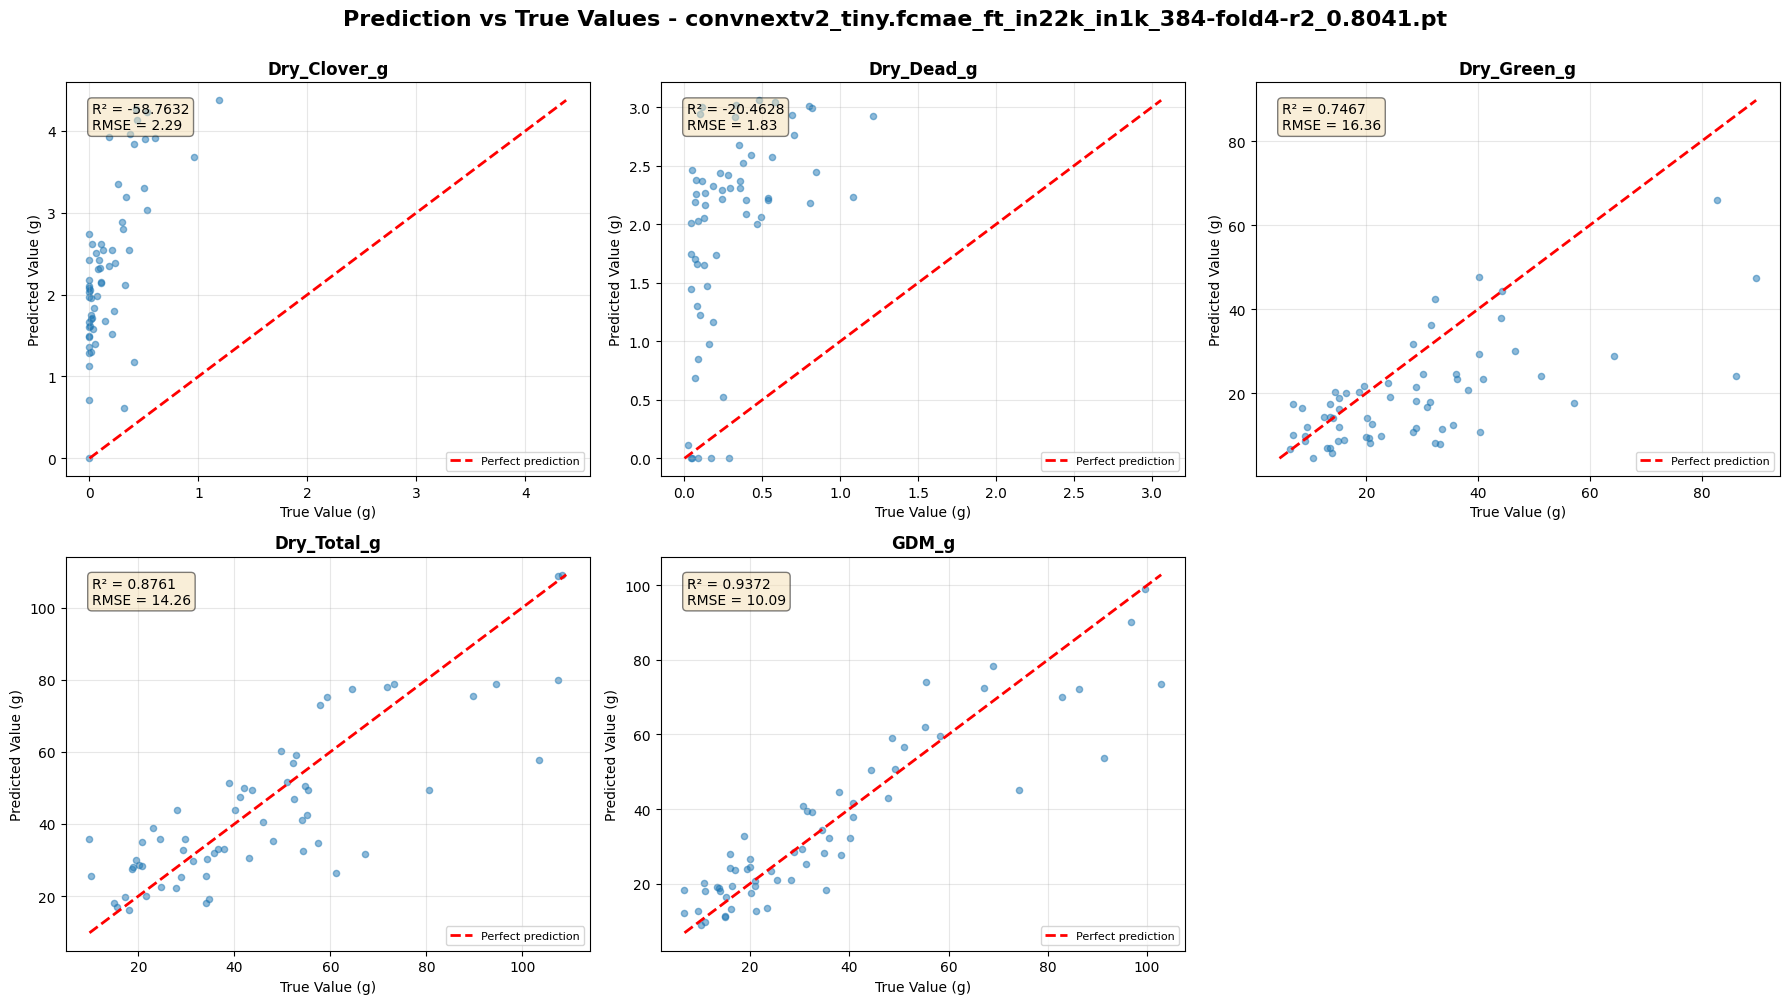

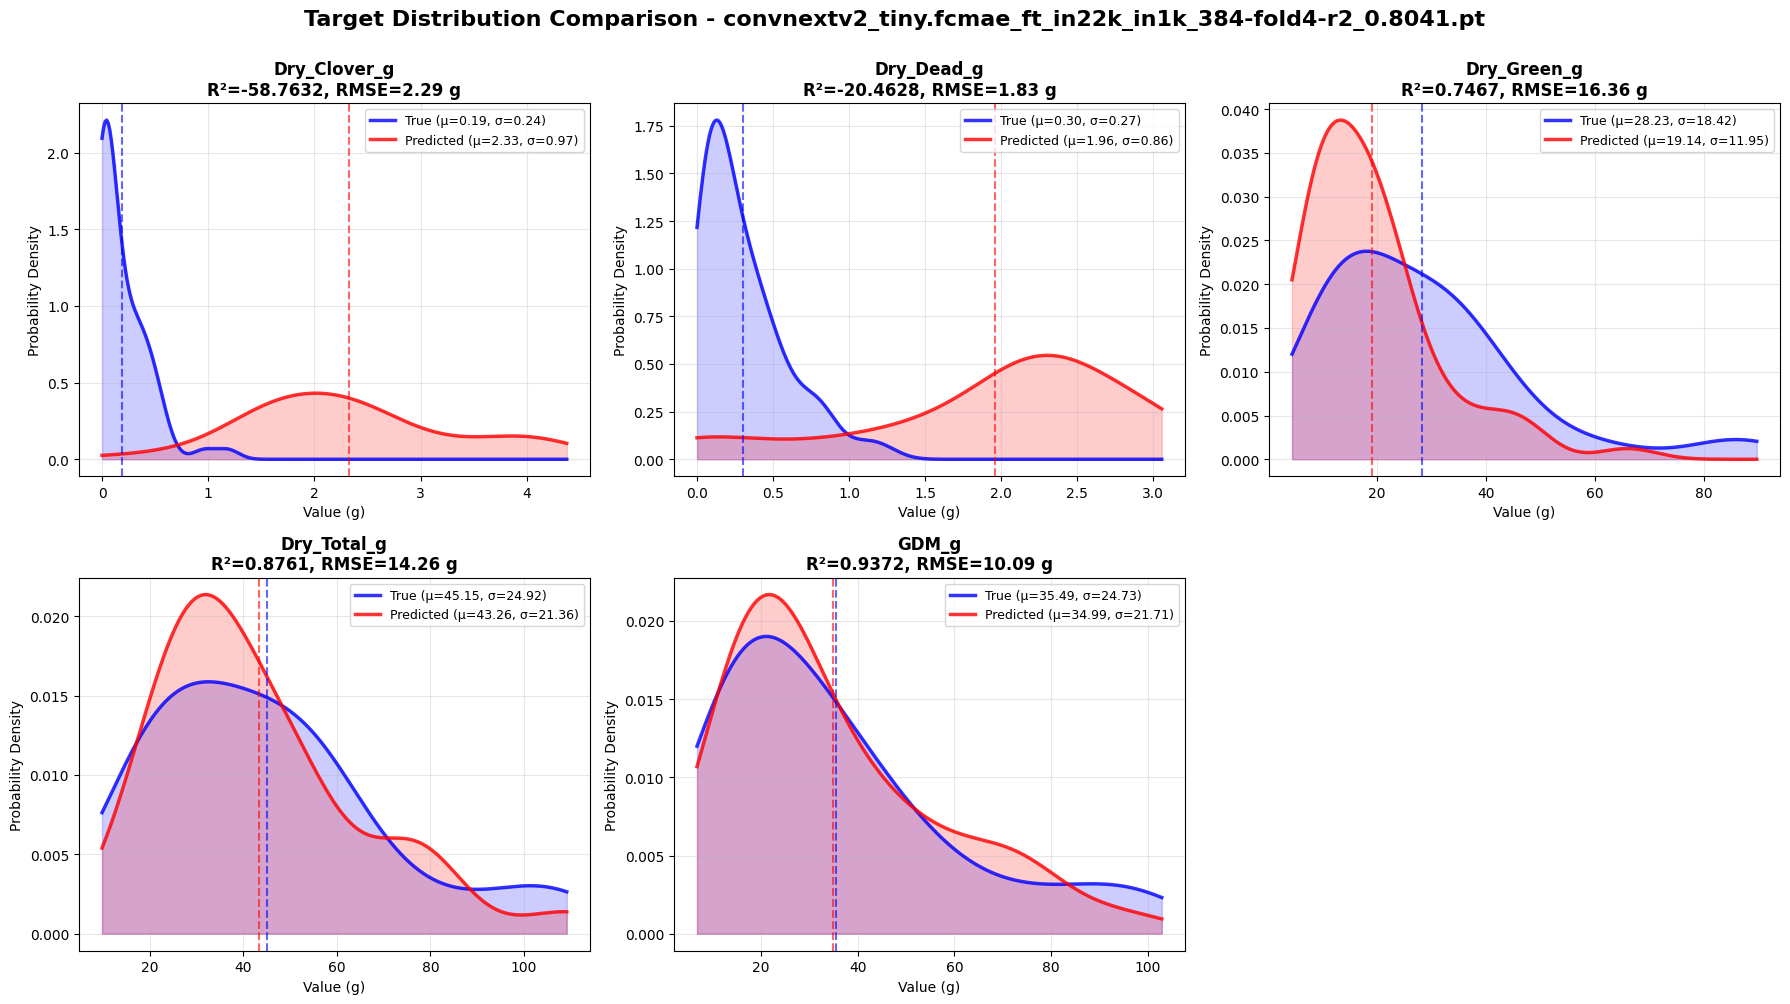


Validating: convnext_base.fb_in22k_ft_in1k-fold0-r2_0.7422.pt


c:\_GitHub\CSIRO-Image2Biomass-Prediction\.venv\Lib\site-packages\torch\serialization.py:1493: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn(


✅ Model loaded successfully

Fold 0:
  Train samples: 285
  Val samples: 72
  ✓ No date overlap (train: 24 dates, val: 4 dates)

Fold 1:
  Train samples: 282
  Val samples: 75
  ✓ No date overlap (train: 21 dates, val: 7 dates)

Fold 2:
  Train samples: 285
  Val samples: 72
  ✓ No date overlap (train: 21 dates, val: 7 dates)

Fold 3:
  Train samples: 297
  Val samples: 60
  ✓ No date overlap (train: 24 dates, val: 4 dates)

Fold 4:
  Train samples: 279
  Val samples: 78
  ✓ No date overlap (train: 22 dates, val: 6 dates)
FOLD QUALITY VERIFICATION

Fold 0:
  Samples: 72
  State distribution:
    Tas: 52.8%
    Vic: 34.7%
    NSW: 12.5%
  Species distribution:
    Ryegrass_Clover: 37.5%
    Clover: 15.3%
    Ryegrass: 13.9%
    Fescue: 12.5%
    Phalaris_Ryegrass_Clover: 9.7%
    Phalaris_Clover: 8.3%
    Mixed: 2.8%
  Season distribution:
    Winter: 59.7%
    Spring: 27.8%
    Summer: 12.5%
  Mass bin distribution:
    mass_bin_0: 25.0%
    mass_bin_1: 22.2%
    mass_bin_2: 19.4%
    

Validating: 100%|██████████| 5/5 [00:12<00:00,  2.60s/it]



📊 Results for convnext_base.fb_in22k_ft_in1k-fold0-r2_0.7422.pt:
  Dry_Clover_g:
    R² = -1.4831
    RMSE = 1.76 g
    MAE = 1.63 g
    Mean Error = 1.62 g
    Overprediction Ratio = 97.22%
  Dry_Dead_g:
    R² = -7.2633
    RMSE = 1.98 g
    MAE = 1.88 g
    Mean Error = 1.86 g
    Overprediction Ratio = 98.61%
  Dry_Green_g:
    R² = 0.7439
    RMSE = 14.04 g
    MAE = 8.71 g
    Mean Error = 0.02 g
    Overprediction Ratio = 55.56%
  Dry_Total_g:
    R² = 0.8195
    RMSE = 16.22 g
    MAE = 12.18 g
    Mean Error = 0.82 g
    Overprediction Ratio = 56.94%
  GDM_g:
    R² = 0.8323
    RMSE = 12.90 g
    MAE = 9.40 g
    Mean Error = 3.89 g
    Overprediction Ratio = 73.61%

🏆 Competition R² Score: 0.7315


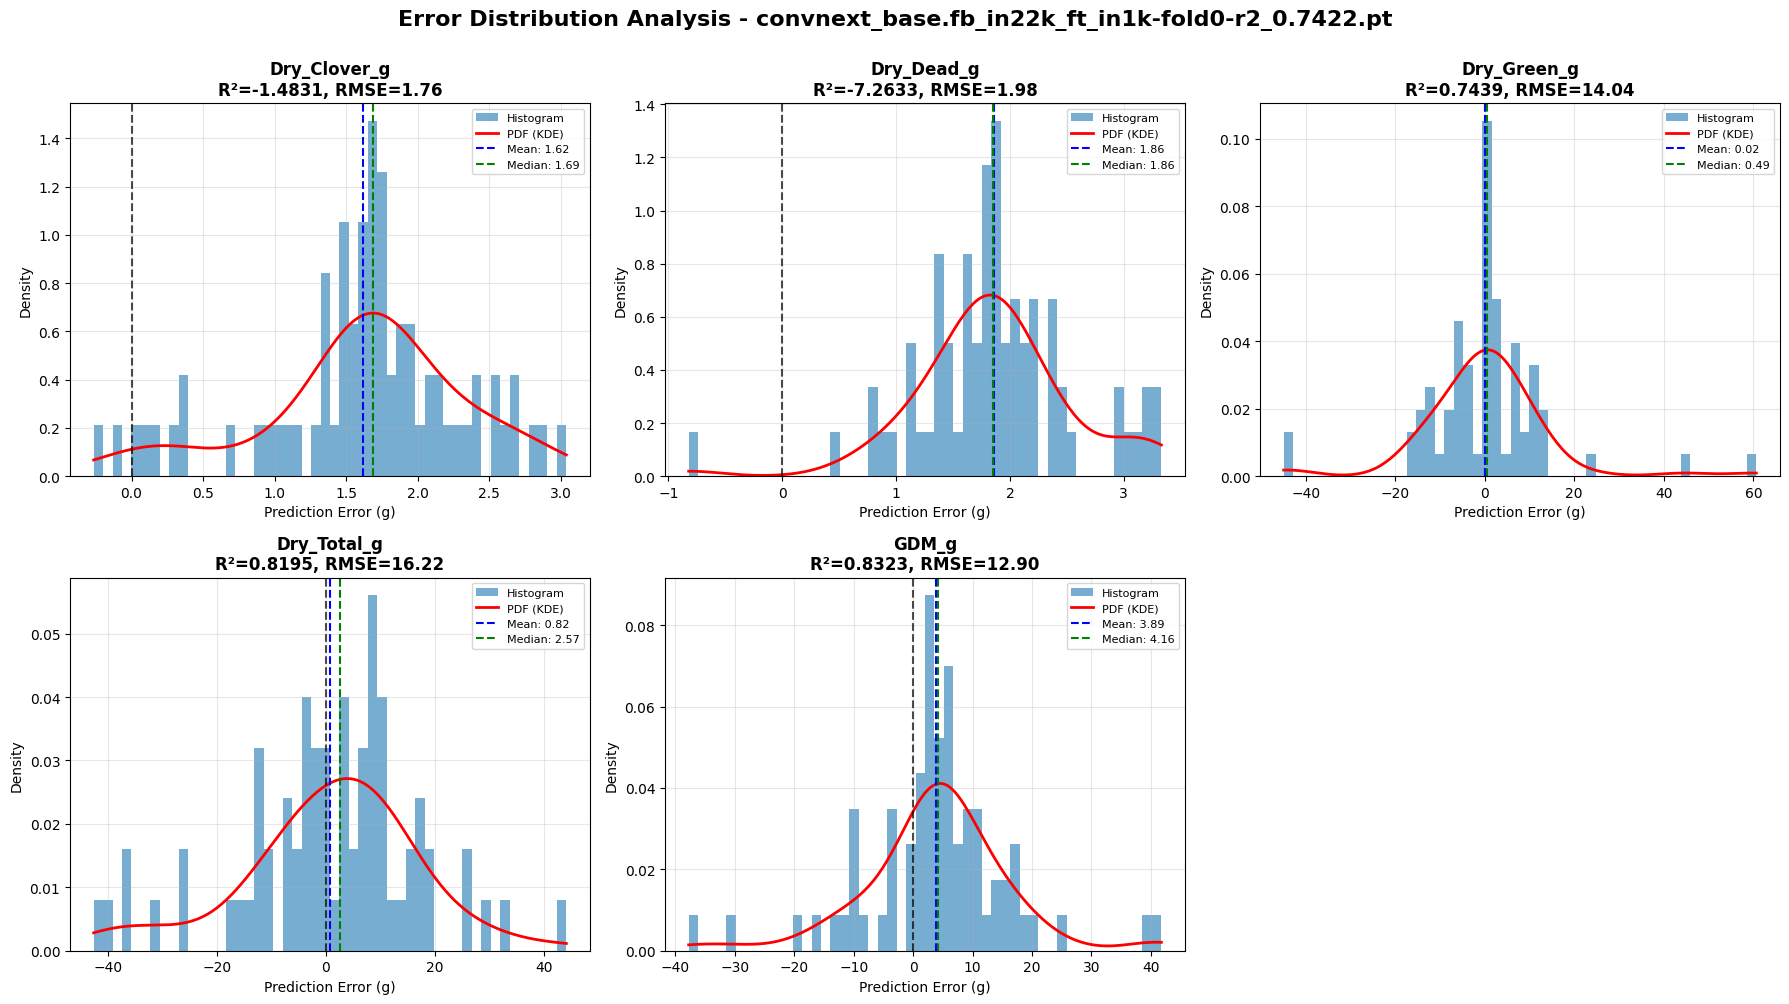

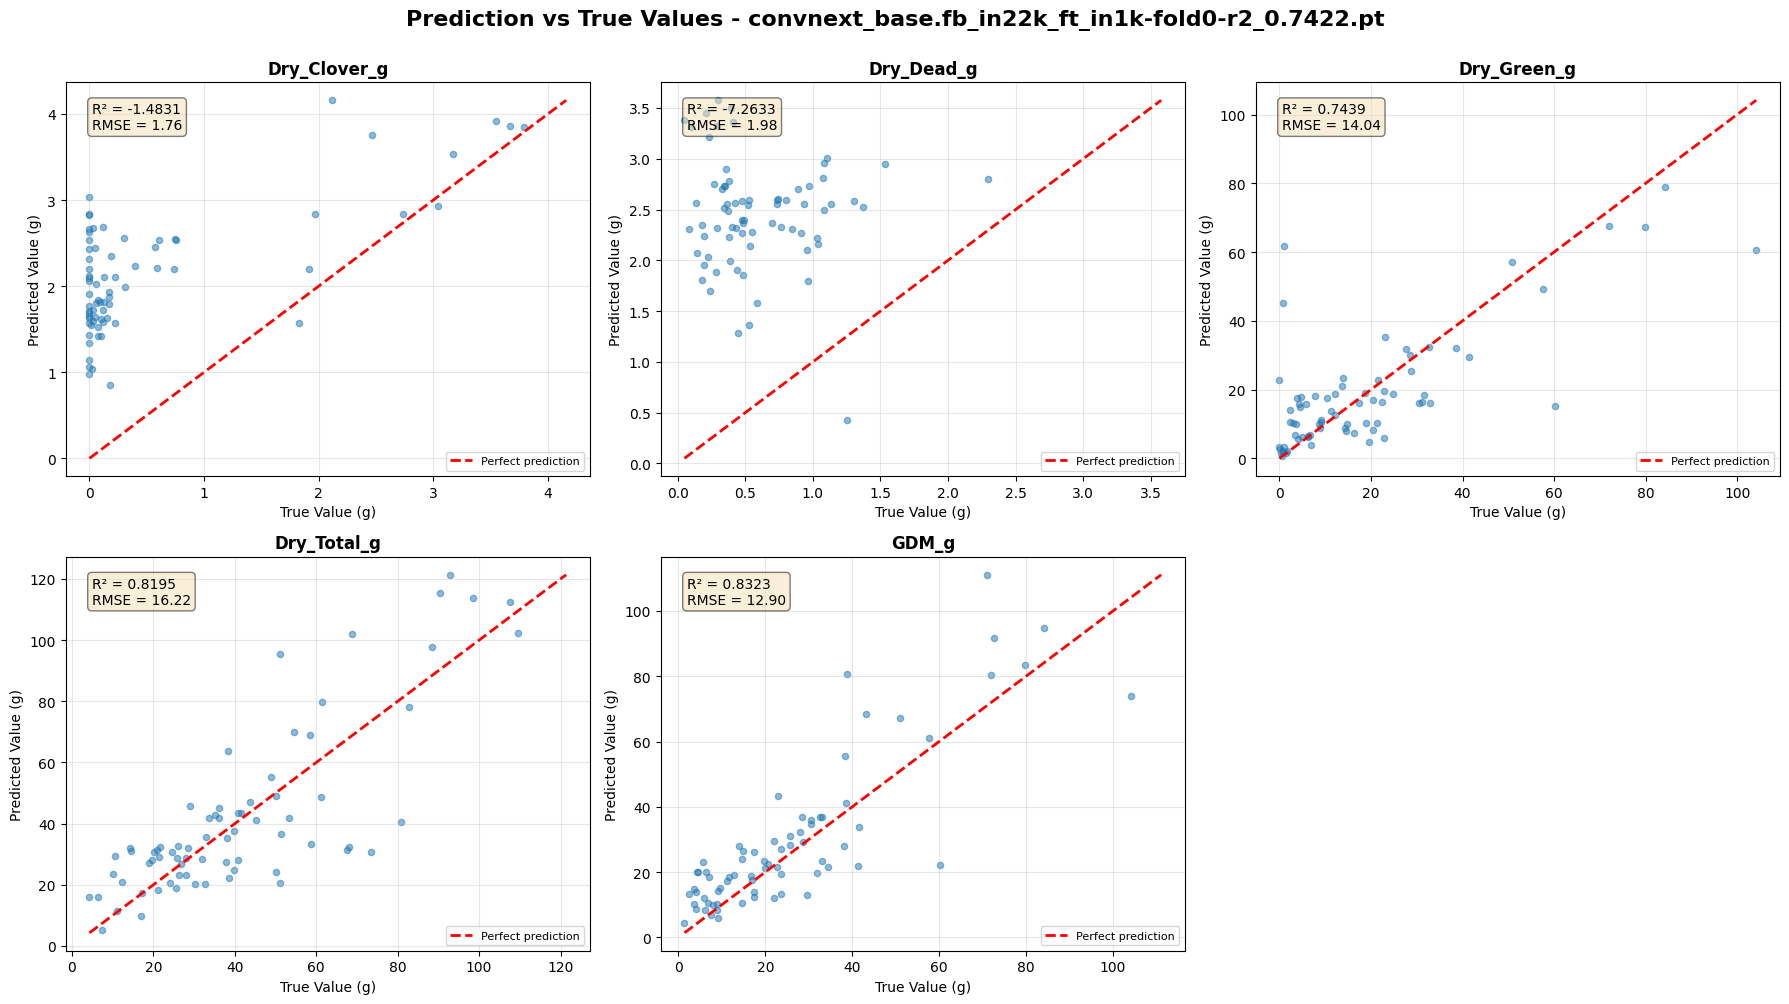

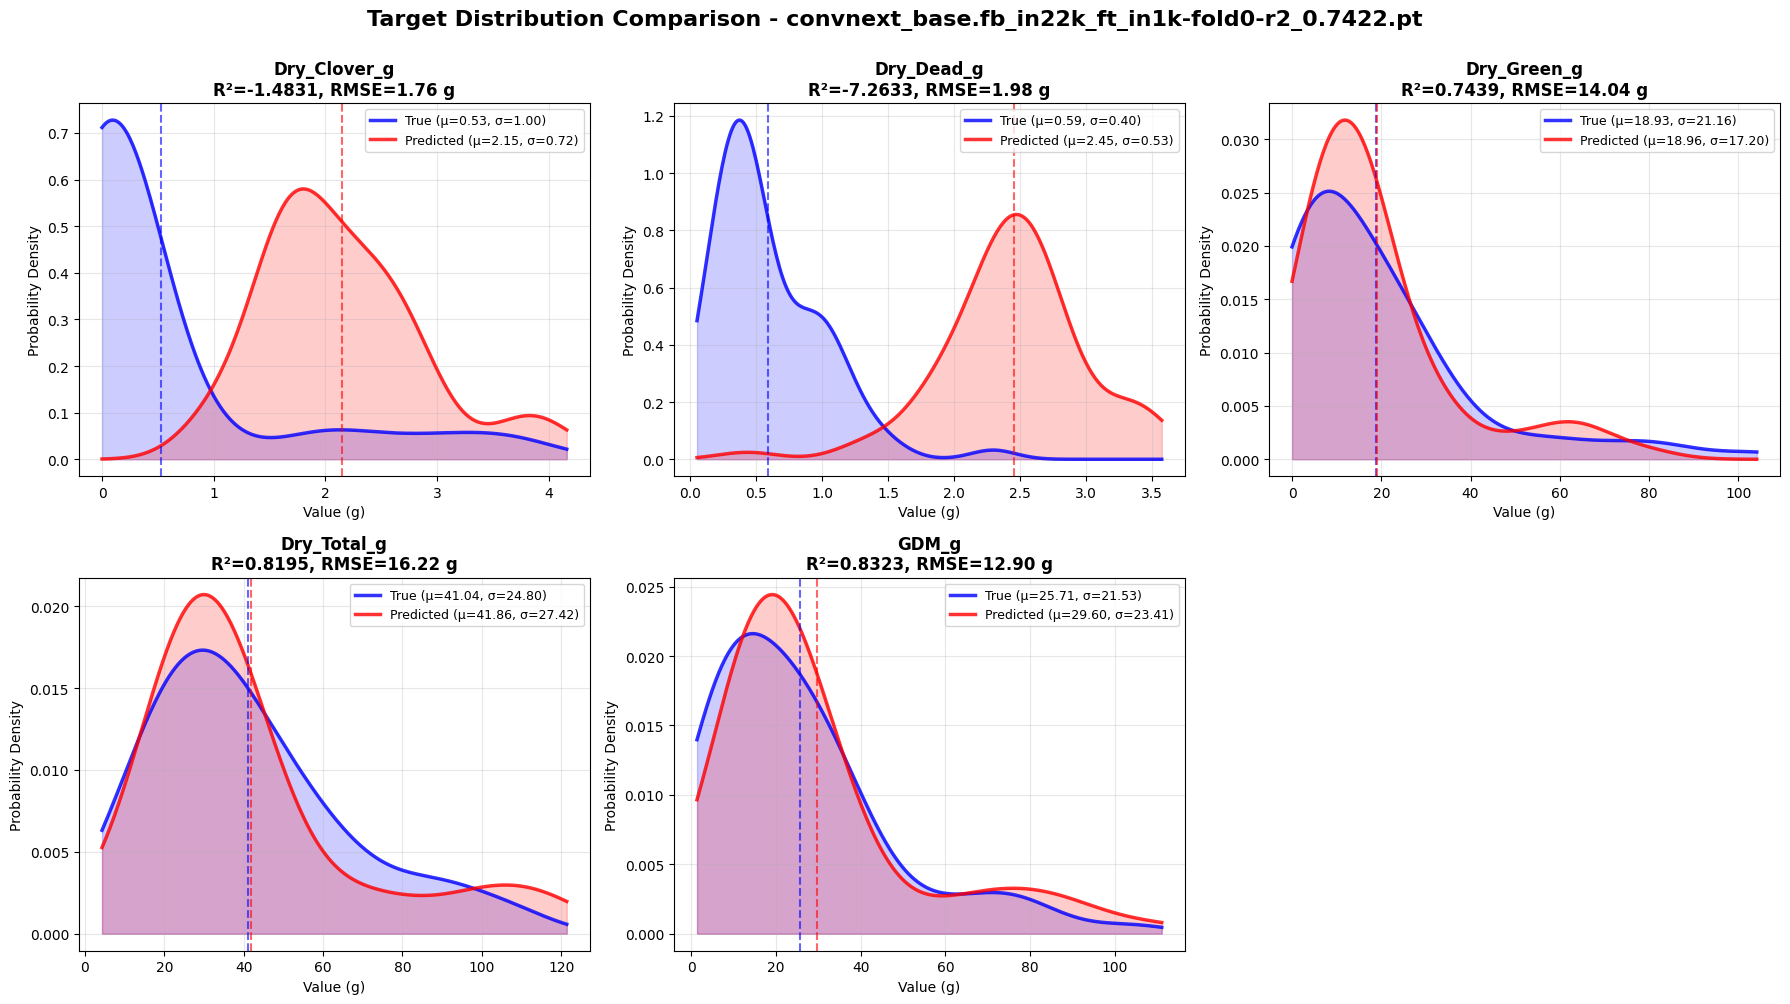


Validating: GPU_vit_large_patch16_dinov3.lvd1689m-fold1-r2_0.8214.pt


c:\_GitHub\CSIRO-Image2Biomass-Prediction\.venv\Lib\site-packages\torch\serialization.py:1493: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn(


✅ Model loaded successfully

Fold 0:
  Train samples: 285
  Val samples: 72
  ✓ No date overlap (train: 24 dates, val: 4 dates)

Fold 1:
  Train samples: 282
  Val samples: 75
  ✓ No date overlap (train: 21 dates, val: 7 dates)

Fold 2:
  Train samples: 285
  Val samples: 72
  ✓ No date overlap (train: 21 dates, val: 7 dates)

Fold 3:
  Train samples: 297
  Val samples: 60
  ✓ No date overlap (train: 24 dates, val: 4 dates)

Fold 4:
  Train samples: 279
  Val samples: 78
  ✓ No date overlap (train: 22 dates, val: 6 dates)
FOLD QUALITY VERIFICATION

Fold 0:
  Samples: 72
  State distribution:
    Tas: 52.8%
    Vic: 34.7%
    NSW: 12.5%
  Species distribution:
    Ryegrass_Clover: 37.5%
    Clover: 15.3%
    Ryegrass: 13.9%
    Fescue: 12.5%
    Phalaris_Ryegrass_Clover: 9.7%
    Phalaris_Clover: 8.3%
    Mixed: 2.8%
  Season distribution:
    Winter: 59.7%
    Spring: 27.8%
    Summer: 12.5%
  Mass bin distribution:
    mass_bin_0: 25.0%
    mass_bin_1: 22.2%
    mass_bin_2: 19.4%
    

Validating: 100%|██████████| 5/5 [00:26<00:00,  5.27s/it]



📊 Results for GPU_vit_large_patch16_dinov3.lvd1689m-fold1-r2_0.8214.pt:
  Dry_Clover_g:
    R² = -1.4232
    RMSE = 1.32 g
    MAE = 0.98 g
    Mean Error = 0.94 g
    Overprediction Ratio = 66.67%
  Dry_Dead_g:
    R² = -14.5340
    RMSE = 2.24 g
    MAE = 2.10 g
    Mean Error = 2.10 g
    Overprediction Ratio = 97.33%
  Dry_Green_g:
    R² = 0.8340
    RMSE = 17.24 g
    MAE = 10.80 g
    Mean Error = 0.99 g
    Overprediction Ratio = 38.67%
  Dry_Total_g:
    R² = 0.8206
    RMSE = 18.13 g
    MAE = 11.43 g
    Mean Error = 3.50 g
    Overprediction Ratio = 60.00%
  GDM_g:
    R² = 0.8196
    RMSE = 18.44 g
    MAE = 13.41 g
    Mean Error = -0.47 g
    Overprediction Ratio = 44.00%

🏆 Competition R² Score: 0.7215


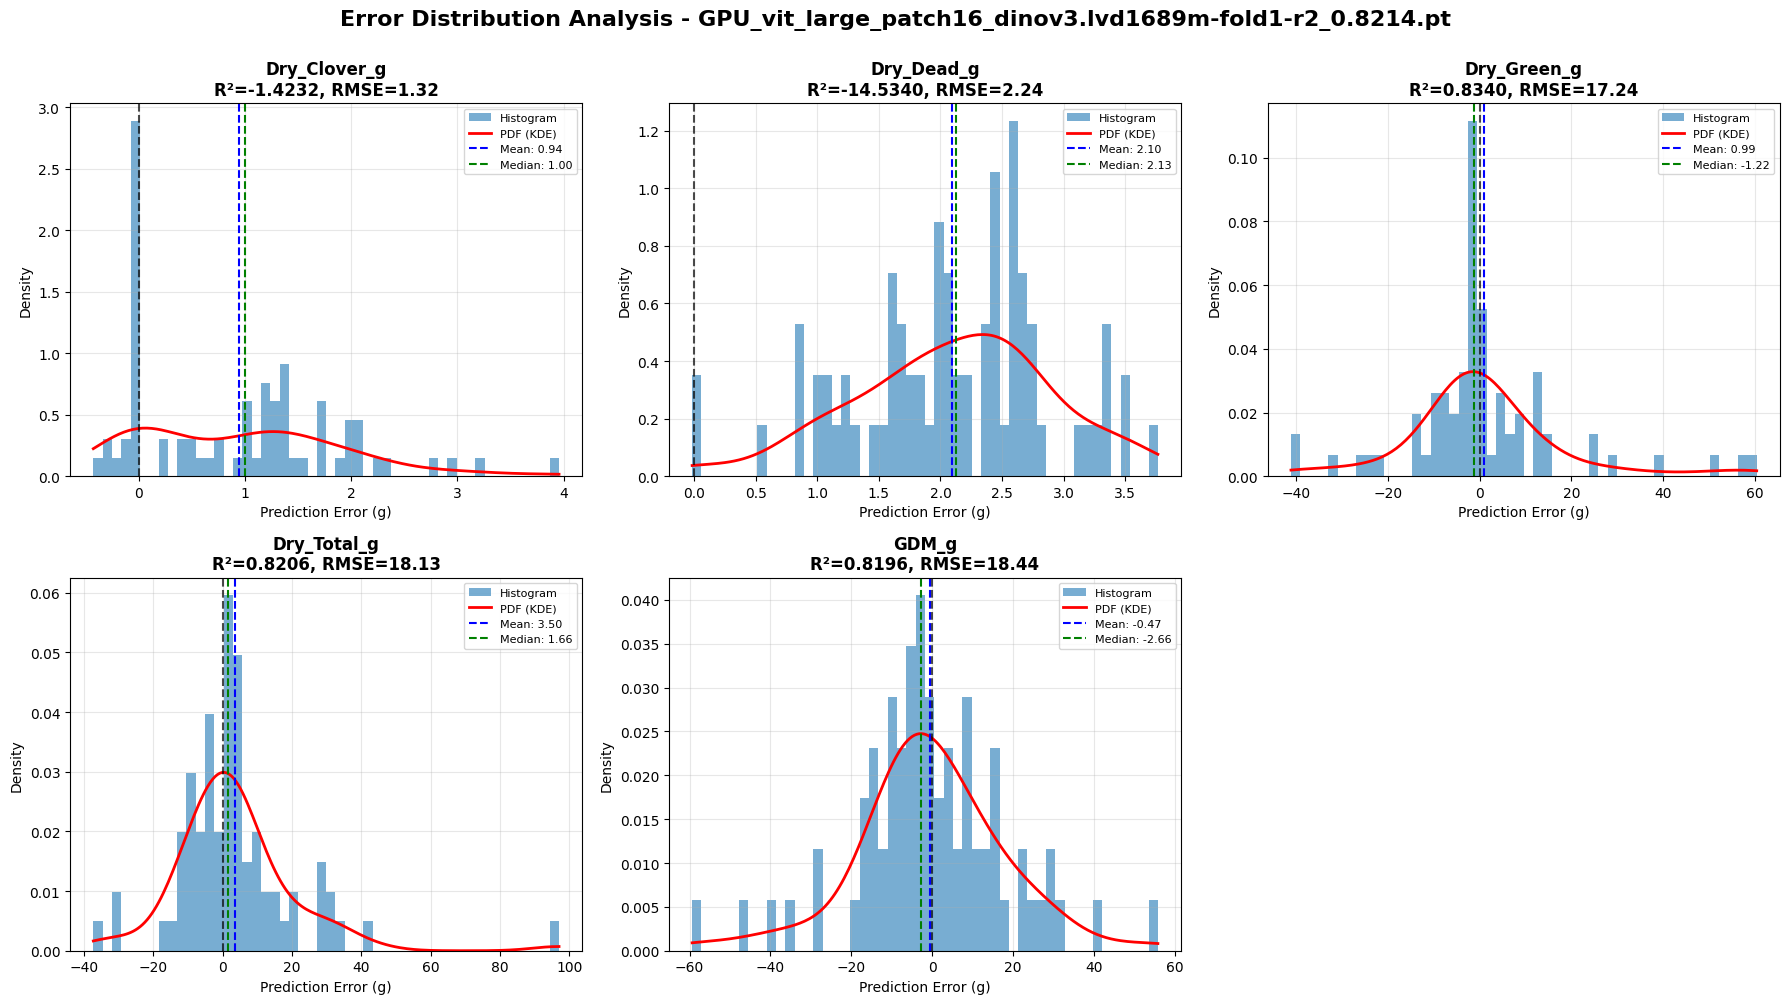

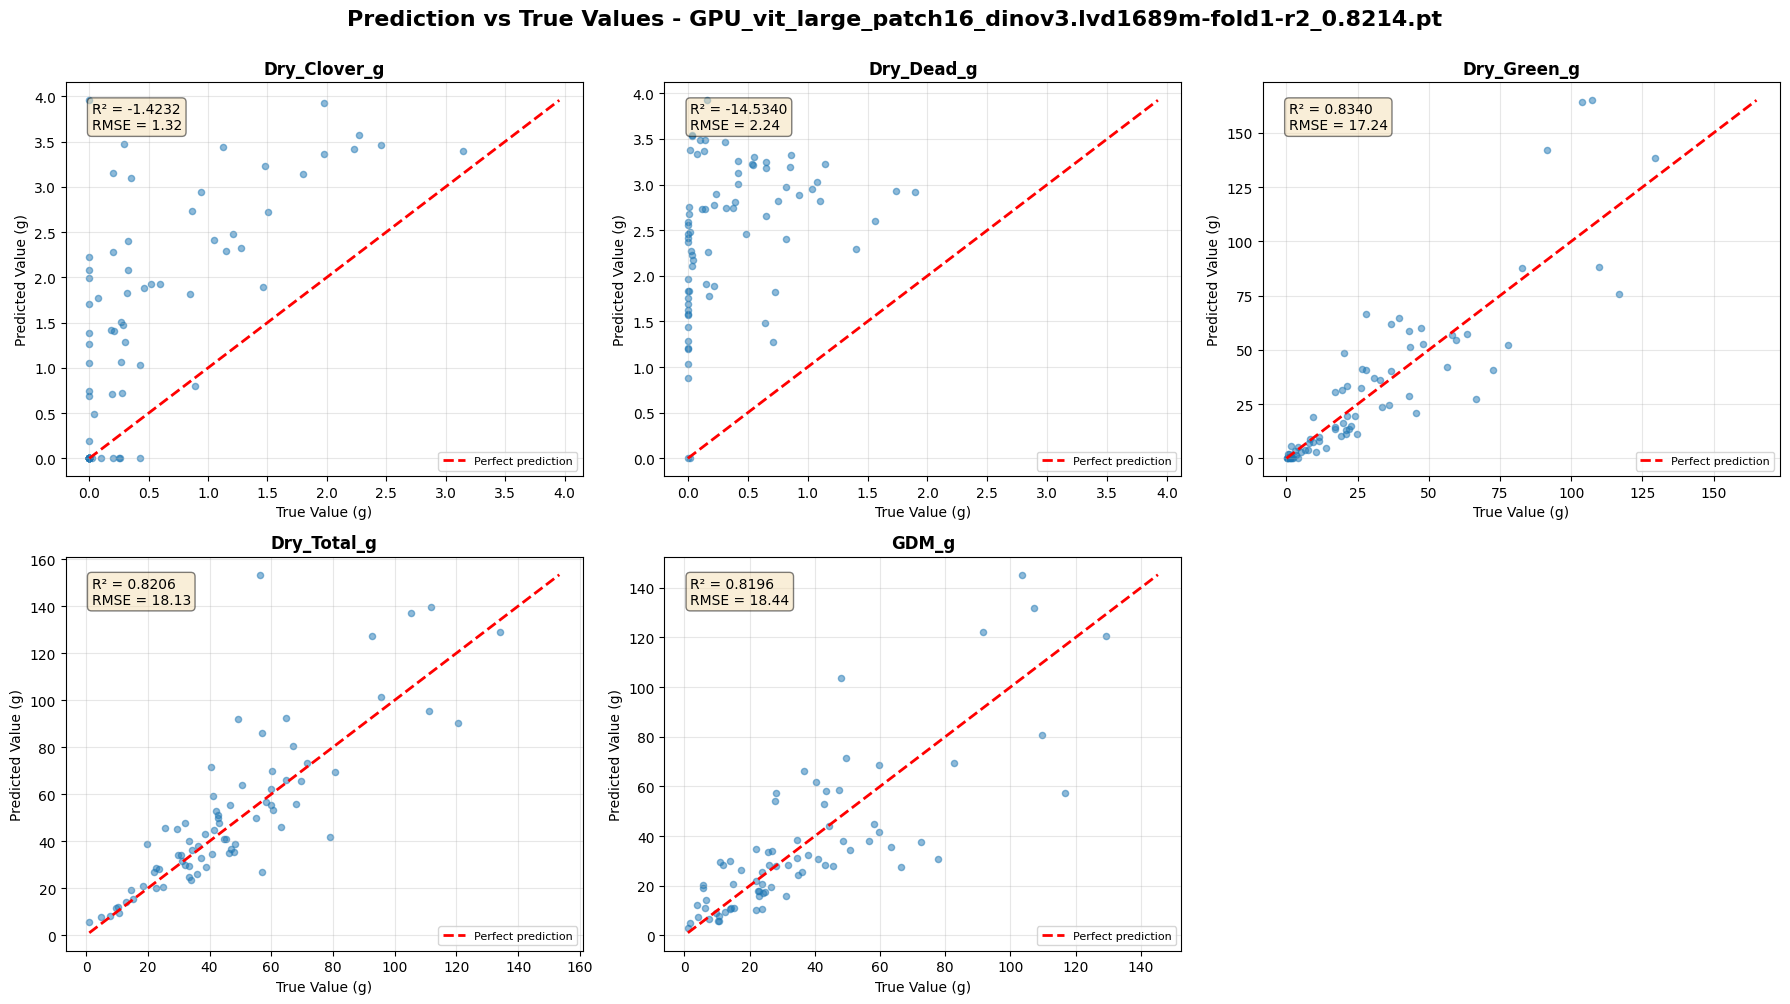

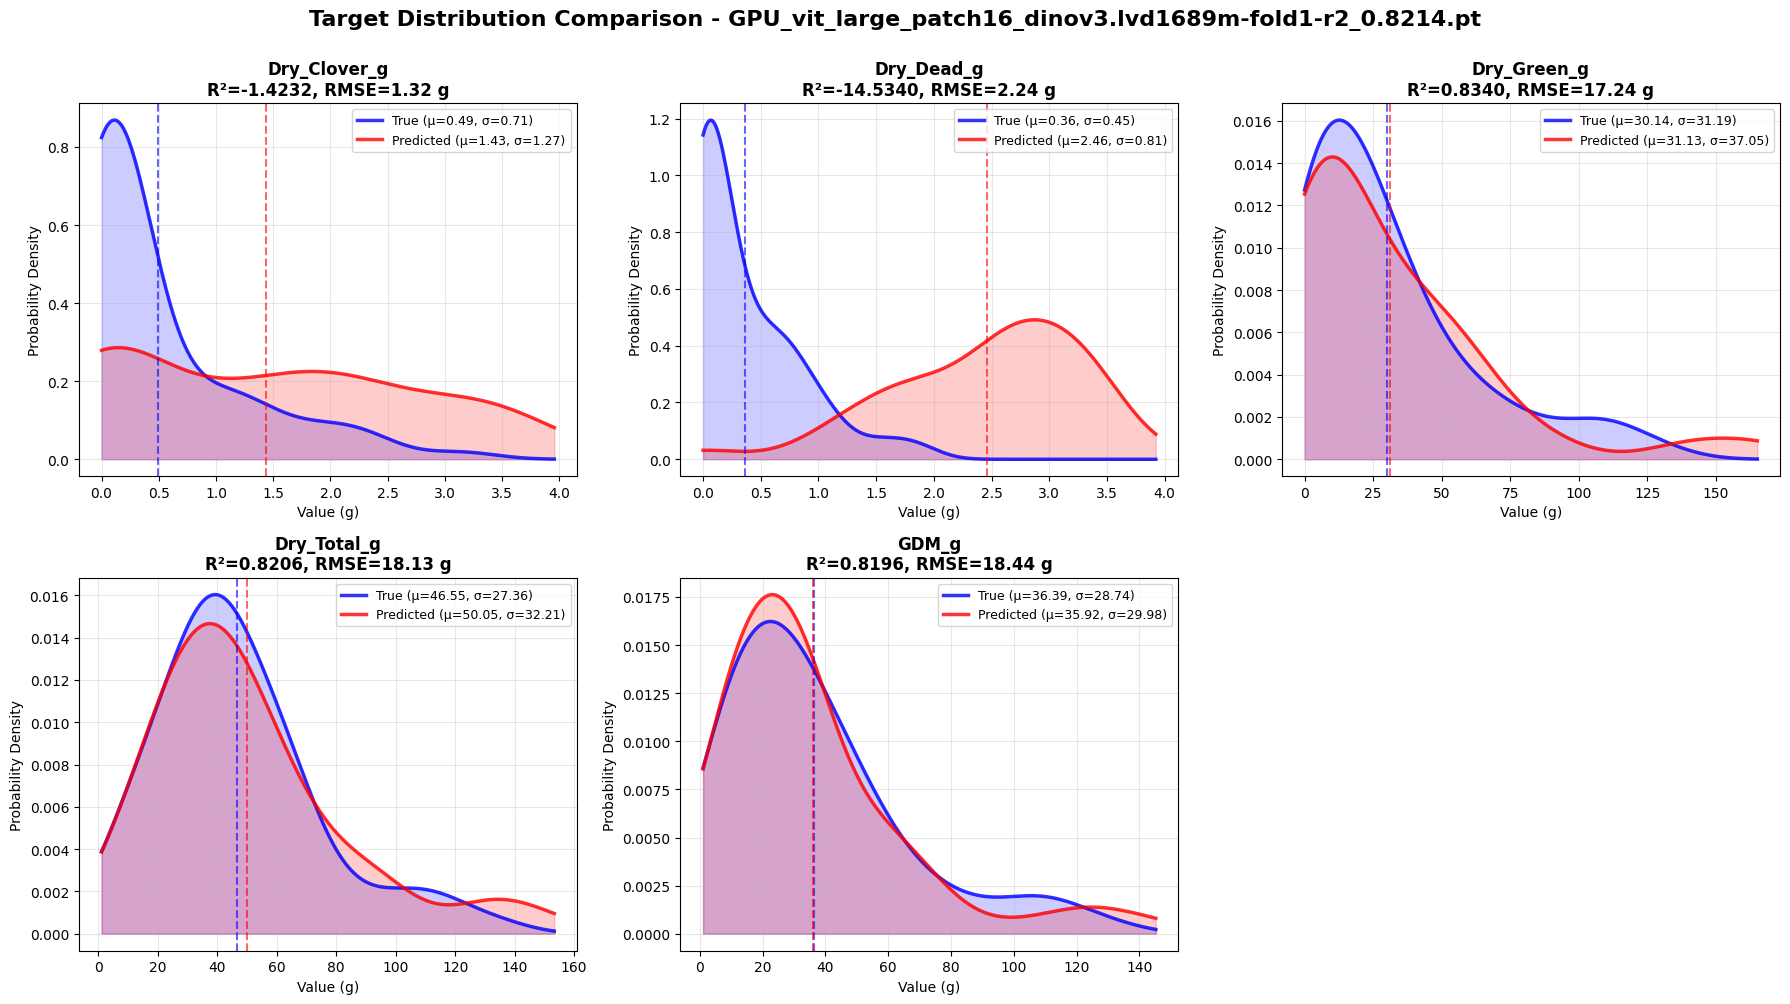


Validating: vit_large_patch14_dinov2.lvd142m-fold4-r2_0.7603.pt


c:\_GitHub\CSIRO-Image2Biomass-Prediction\.venv\Lib\site-packages\torch\serialization.py:1493: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn(


✅ Model loaded successfully

Fold 0:
  Train samples: 285
  Val samples: 72
  ✓ No date overlap (train: 24 dates, val: 4 dates)

Fold 1:
  Train samples: 282
  Val samples: 75
  ✓ No date overlap (train: 21 dates, val: 7 dates)

Fold 2:
  Train samples: 285
  Val samples: 72
  ✓ No date overlap (train: 21 dates, val: 7 dates)

Fold 3:
  Train samples: 297
  Val samples: 60
  ✓ No date overlap (train: 24 dates, val: 4 dates)

Fold 4:
  Train samples: 279
  Val samples: 78
  ✓ No date overlap (train: 22 dates, val: 6 dates)
FOLD QUALITY VERIFICATION

Fold 0:
  Samples: 72
  State distribution:
    Tas: 52.8%
    Vic: 34.7%
    NSW: 12.5%
  Species distribution:
    Ryegrass_Clover: 37.5%
    Clover: 15.3%
    Ryegrass: 13.9%
    Fescue: 12.5%
    Phalaris_Ryegrass_Clover: 9.7%
    Phalaris_Clover: 8.3%
    Mixed: 2.8%
  Season distribution:
    Winter: 59.7%
    Spring: 27.8%
    Summer: 12.5%
  Mass bin distribution:
    mass_bin_0: 25.0%
    mass_bin_1: 22.2%
    mass_bin_2: 19.4%
    

Validating: 100%|██████████| 5/5 [00:43<00:00,  8.79s/it]



📊 Results for vit_large_patch14_dinov2.lvd142m-fold4-r2_0.7603.pt:
  Dry_Clover_g:
    R² = -6.7120
    RMSE = 1.90 g
    MAE = 1.31 g
    Mean Error = 1.29 g
    Overprediction Ratio = 57.69%
  Dry_Dead_g:
    R² = -16.7873
    RMSE = 2.01 g
    MAE = 1.76 g
    Mean Error = 1.71 g
    Overprediction Ratio = 76.92%
  Dry_Green_g:
    R² = 0.5523
    RMSE = 19.85 g
    MAE = 14.55 g
    Mean Error = 3.72 g
    Overprediction Ratio = 58.97%
  Dry_Total_g:
    R² = 0.8745
    RMSE = 13.94 g
    MAE = 11.08 g
    Mean Error = 7.63 g
    Overprediction Ratio = 83.33%
  GDM_g:
    R² = 0.8625
    RMSE = 13.73 g
    MAE = 10.83 g
    Mean Error = 8.50 g
    Overprediction Ratio = 84.62%

🏆 Competition R² Score: 0.7528


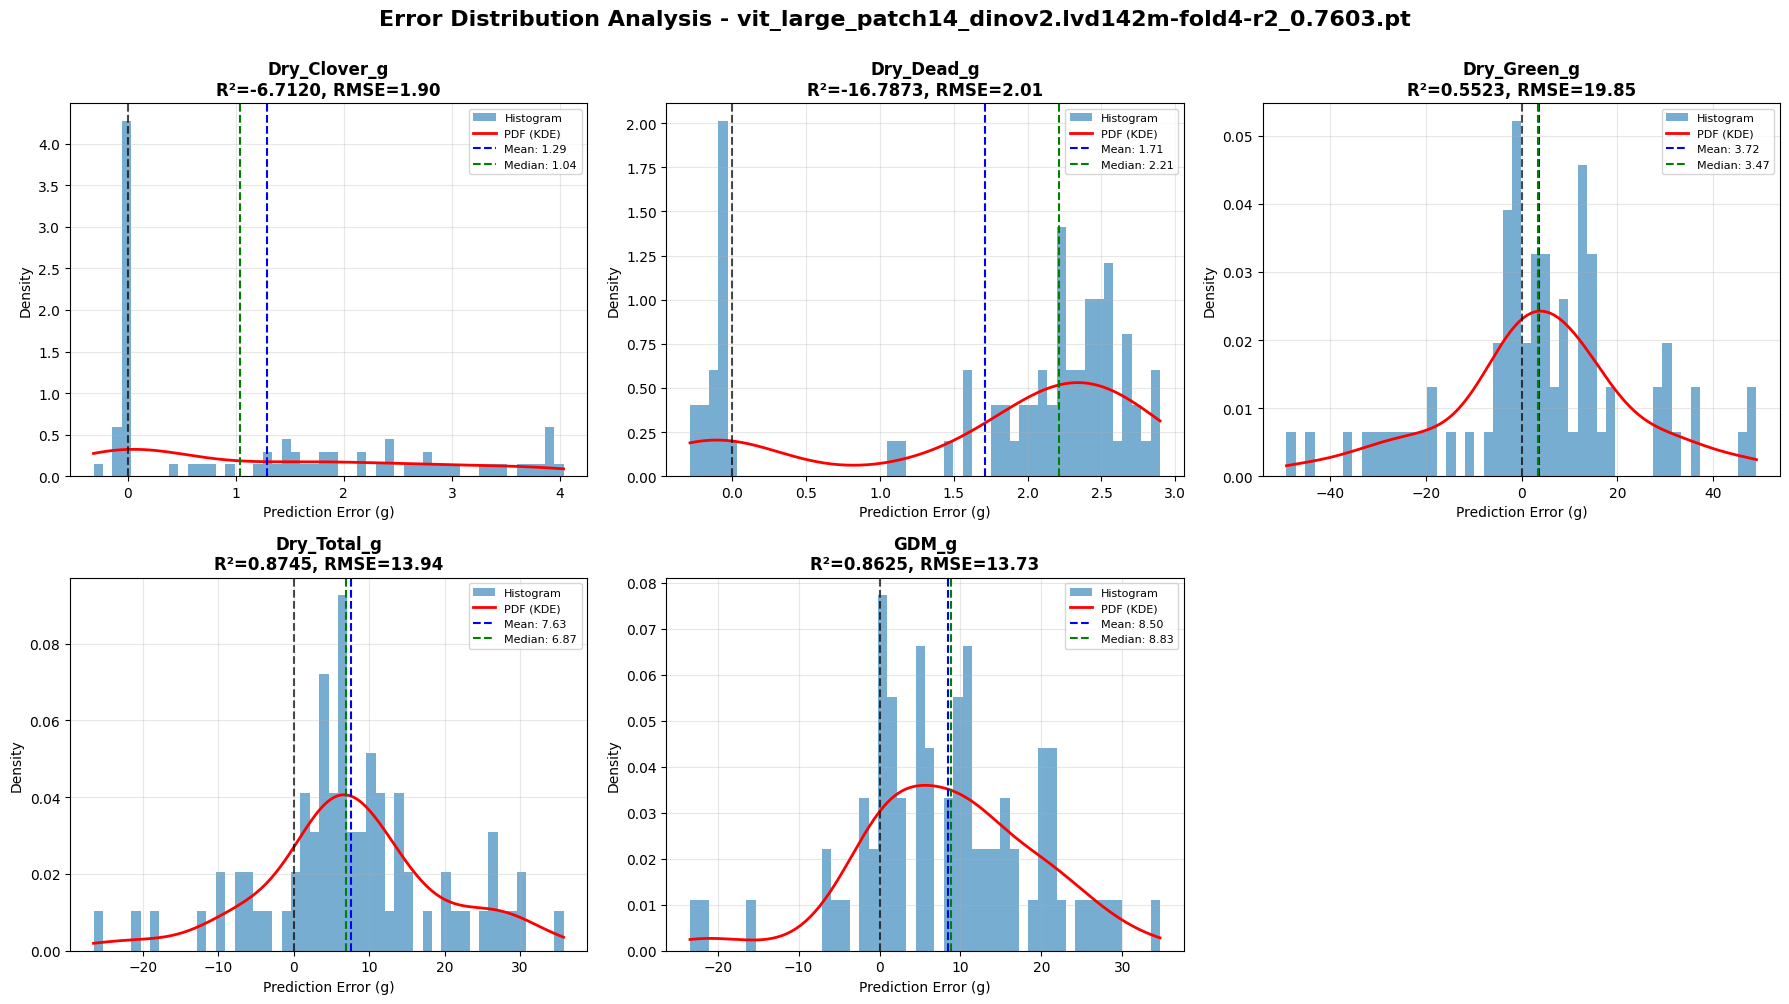

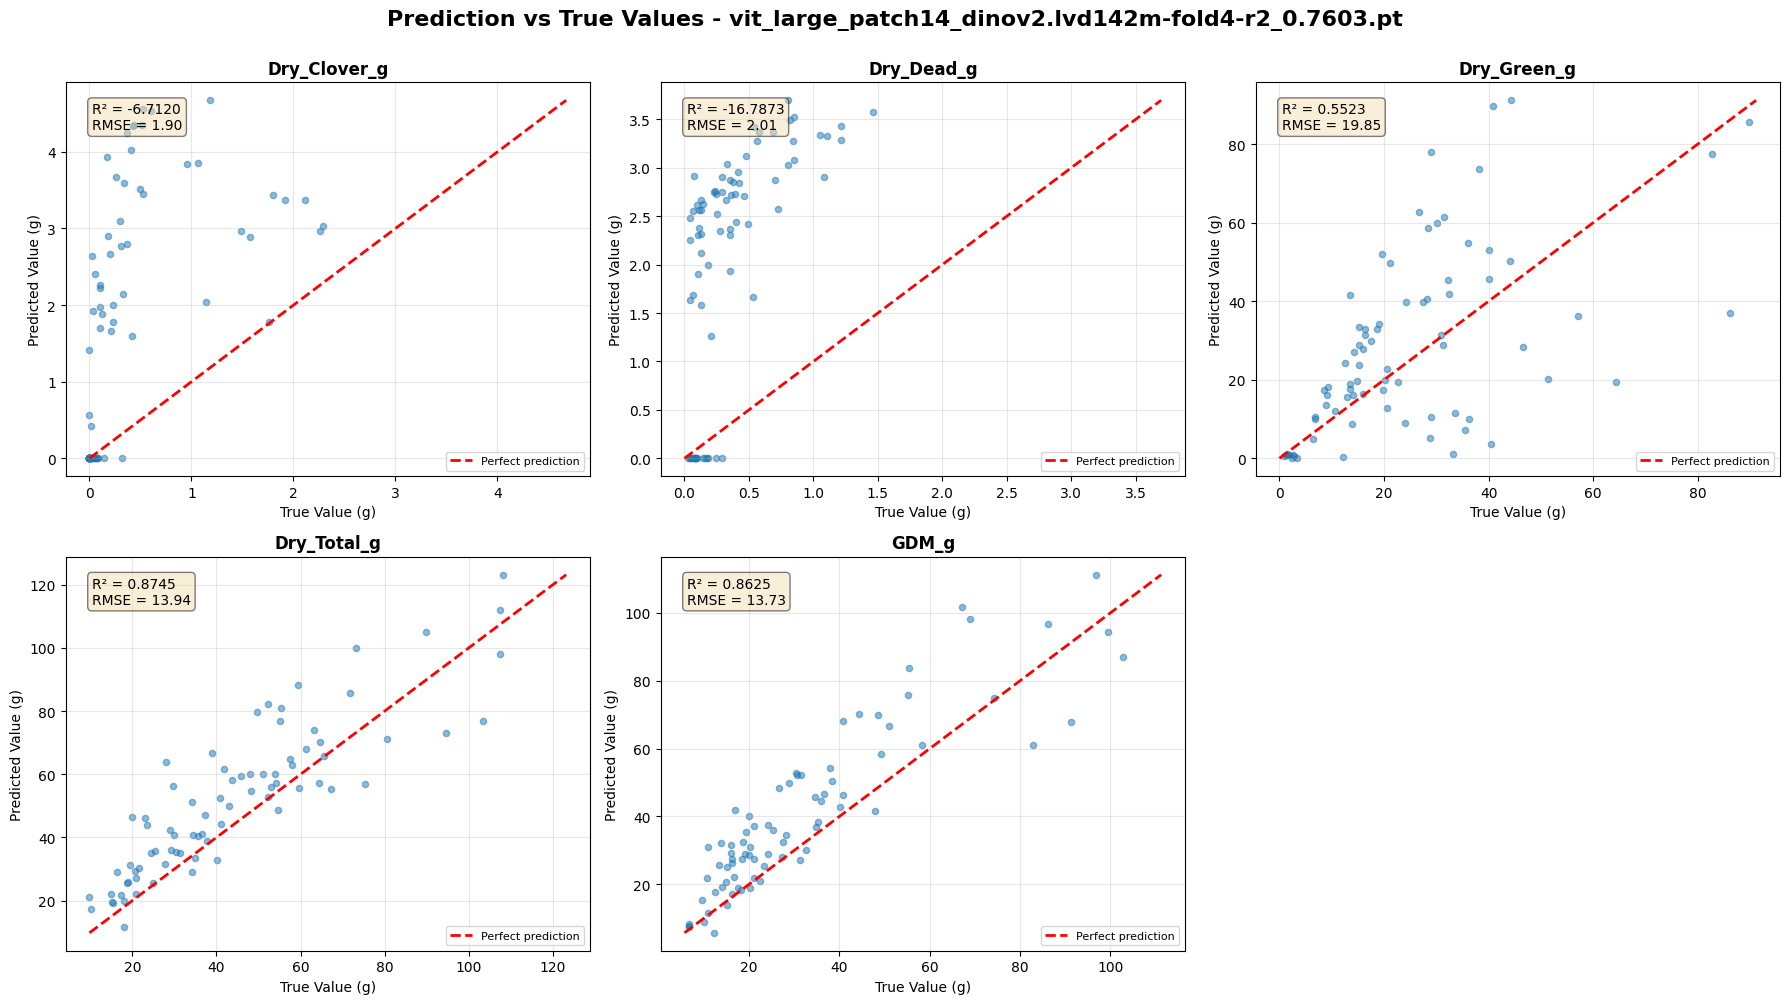

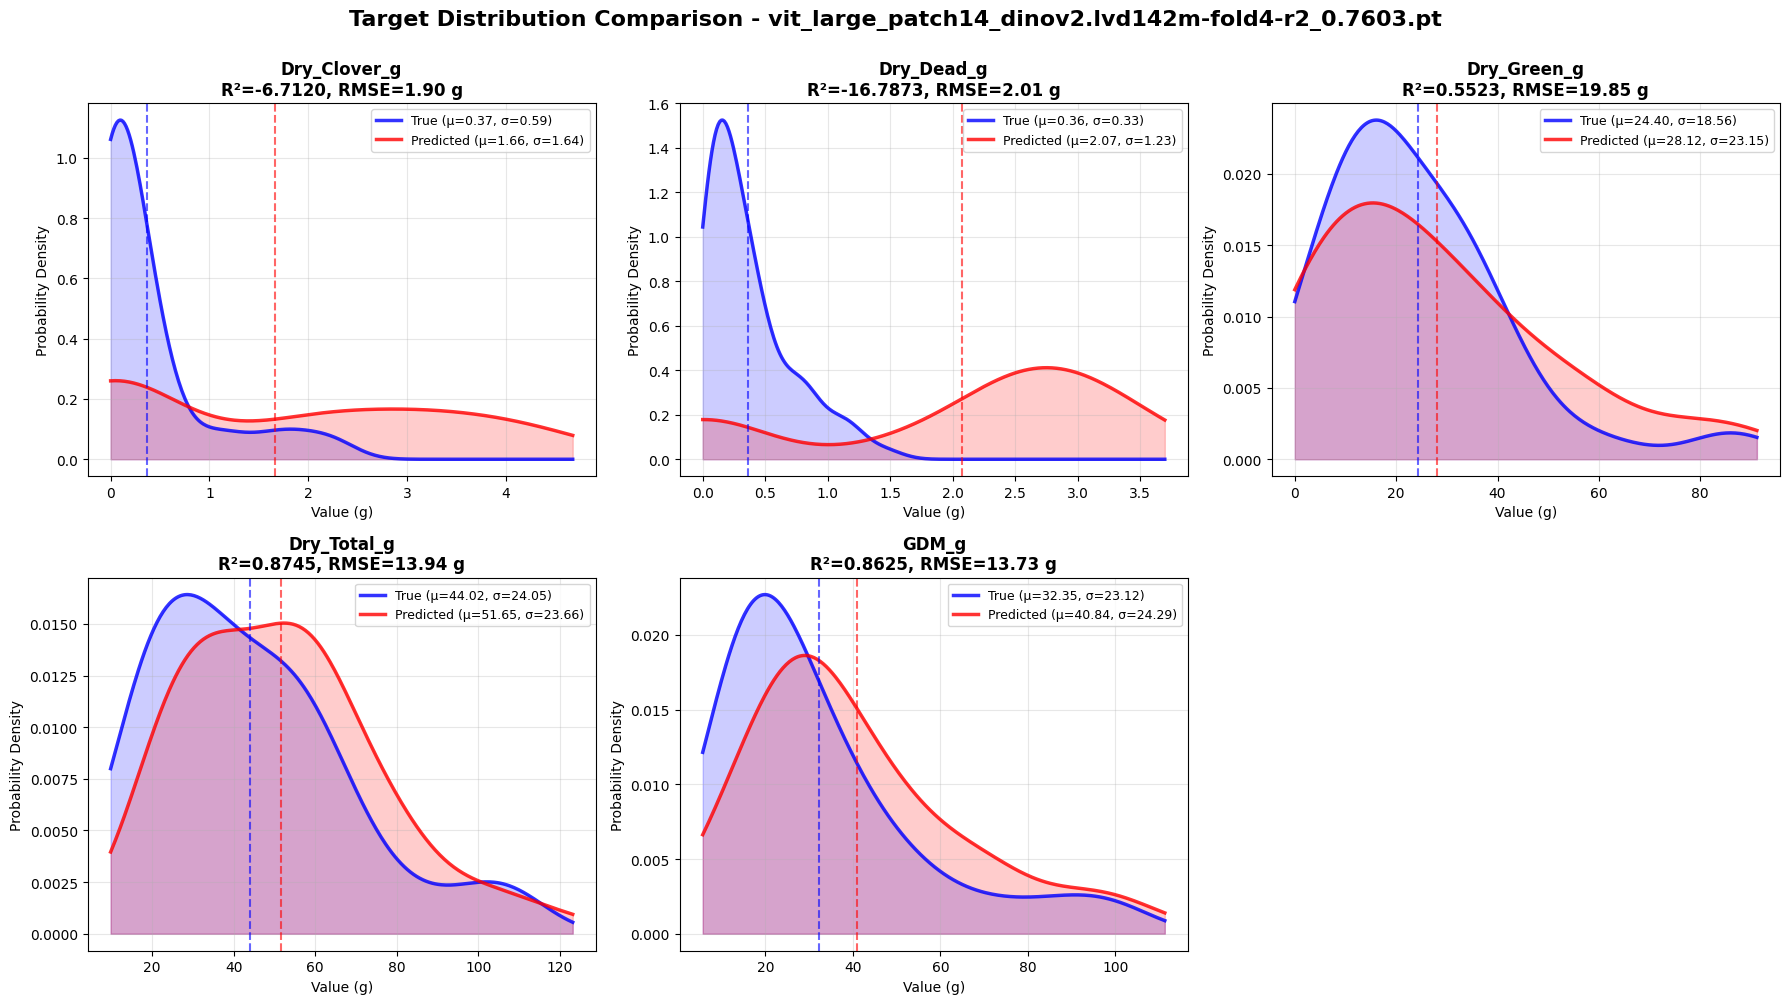

In [36]:
# Store all results
all_model_results = {}

for model_path in all_models:
    model_name = os.path.basename(model_path)
    print(f"\n{'='*80}")
    print(f"Validating: {model_name}")
    print(f"{'='*80}")

    # Get config or use defaults
    config = MODEL_CONFIGS[model_name]

    try:
        # Load model
        model = torch.load(model_path, map_location=DEVICE, weights_only=False)
        model.to(DEVICE)
        model.eval()
        print(f"✅ Model loaded successfully")

        # Get validation loader
        val_loader, val_df = get_validation_loader(
            df=df_pivoted,
            fold=config['fold'],
            img_size=config['img_size'],
            mean=config['mean'],
            std=config['std'],
            use_log_target=config['use_log_target'],
            seed=config['seed'],
            batch_size=BATCH_SIZE,
            num_workers=NUM_WORKERS
        )

        # Validate
        predictions, targets = validate_model(
            model=model,
            val_loader=val_loader,
            use_log_target=config['use_log_target'],
            device=DEVICE
        )

        # print(predictions[0], targets[0])

        # Analyze errors
        error_results = analyze_errors(
            predictions=predictions,
            targets=targets,
            target_names=ALL_TARGETS,
            model_name=model_name
        )

        # Store results
        all_model_results[model_name] = error_results

        # Print summary
        print(f"\n📊 Results for {model_name}:")
        for target_name, metrics in error_results.items():
            print(f"  {target_name}:")
            print(f"    R² = {metrics['r2']:.4f}")
            print(f"    RMSE = {metrics['rmse']:.2f} g")
            print(f"    MAE = {metrics['mae']:.2f} g")
            print(f"    Mean Error = {metrics['mean_error']:.2f} g")
            print(
                f"    Overprediction Ratio = {metrics['overpredict_ratio']:.2%}")

        # Calculate competition metric
        comp_r2 = competition_metric(targets, predictions)
        print(f"\n🏆 Competition R² Score: {comp_r2:.4f}")

        # Plot results
        plot_error_distribution(error_results, model_name)
        plot_prediction_scatter(error_results, model_name)
        plot_target_distributions(error_results, model_name)

    except Exception as e:
        print(f"❌ Error validating {model_name}: {e}")
        break

    finally:
        # Clean up
        if 'model' in locals():
            del model
        if 'val_loader' in locals():
            del val_loader
        torch.cuda.empty_cache()
        gc.collect()